In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from Common import NeuralNet
import time

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

torch.set_num_threads(8)

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, alpha_f_=0.05, alpha_s_=0.08, h_f_=5, h_s_=6, T_hot_=4, T_0_=1, U_f_=1):
        self.n_int = n_int_     # n_int_:= number of intertior points
        self.n_sb = n_sb_       # n_sb_ := number of spatial boundary points
        self.n_tb = n_tb_       # n_tb_ := number of time boundary points

        # Set the paremeters of the equation
        self.alpha_f = alpha_f_
        self.alpha_s = alpha_s_
        self.h_f = h_f_
        self.h_s = h_s_
        self.T_hot = T_hot_
        self.T_0 = T_0_
        self.U_f = U_f_

        # Extrema of the solution domain (t,x) in [0, t]x[0, L]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the two underlying reaction-convection-diffusion equations
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2, # is a NN with input_dim=2 (time & space), output_dim=2 (fluid_temp & solid_temp)
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])   # it will create a 2 cloumns tensor, the rows nunmber is specified after every time it is used

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.soboleng.draw(self.n_tb)    # input_sb has two columns (t, x) both with random numbers in the two respective domains
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)   # overwrite the entier column of time with t0
        output_tb = torch.full(input_tb.shape, self.T_0)    # also the output has to be with 2 columns, one for T_f & one for T_s

        return input_tb, output_tb  # input_tb is the sequence of x_n; output_tb is the sequence u0(x_n)

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.soboleng.draw(self.n_sb)

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # There are 2 conditions on the function T -> T_x0 & T_xL
        # there are 2 conditions on the function dT/dx -> T_x0_dx & T_xL_dx
        # however we don't have all these contidions for both T_f and T_s (T = [T_f, T_s])
        # We will make 3 of the 4 outputs and fill the vacant conditions with 999
        # and remove them when computing the loss

        # condition T_x0
        output_sb_0 = ((self.T_hot-self.T_0)/(1+torch.exp(-200*(input_sb-0.25)))+self.T_0)  # is a tensor with two columns [T_f, T_s], however we will just want to use the first one
        output_sb_0[:,1] = torch.full(input_sb[:, 1].shape, 999)
        # condition T_x0_dx
        output_sb_0_dx = torch.zeros_like(input_sb)     # is a tensor with two columns as before, we will just want the second one (T_s_dx)
        output_sb_0_dx[:,0] = torch.full(input_sb[:, 1].shape, 999)
        # conditions T_xL_dx
        output_sb_L_dx = torch.zeros_like(input_sb)     # is a tensor with two columns a before, of this we will use both
        
        # requires the grad for these tensors as we will have to compute the derivatives
        input_sb_0.requires_grad_()
        input_sb_L.requires_grad_()

        return torch.cat([input_sb_0, input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_0_dx, output_sb_L_dx], 0)  # we return it like this so we just have to devide input & output in 3 to get each condition

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.soboleng.draw(self.n_int)
        output_int = torch.zeros_like(input_int)
        
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=3*self.space_dimensions*self.n_sb, shuffle=False)  #batch_size has *2 since there are 2 space boundaries conditions
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        # input_tb is a tensor of size [3*self.n_sb, 2]
        # as defined in "add_spatial_boundary_points" we have 3 boundary conditions
        # we then have to devide the input_sb in 3, compute the 3 boundary conditions prediction and return them
        # as done in "add_spatial_boundary_points", we insert 777 for the vacant conditions
        assert (input_sb.requires_grad==True)   # make sure the grad is requested so we can compute the derivatives

        # condition T_x0
        input_sb_0 = input_sb[:int(input_sb.shape[0]/3), :]
        u_pred_sb_0 = self.approximate_solution(input_sb_0)
        u_pred_sb_0[:, 1] = torch.full(u_pred_sb_0[:, 1].shape, 777)
        
        # condition T_x0_dx, here the inputs are the same as for T_x0 and so also u_pred, we will then use them
        u_pred_sb_0_dx = torch.zeros_like(u_pred_sb_0)
        u_pred_sb_0_dx[:, 0] = torch.full(u_pred_sb_0_dx[:, 0].shape, 777)
         
        u_pred_Ts_x0 = self.approximate_solution(input_sb_0)[:, 1]   # just the Ts component from the prediction
        u_pred_Ts_x0_dx = torch.autograd.grad(u_pred_Ts_x0.sum(), input_sb_0 , create_graph=True)[0][:, 1]    # just the dx component
        u_pred_sb_0_dx[:, 1] = u_pred_Ts_x0_dx

        # conditions T_xL_dx
        input_sb_L = input_sb[int(2*input_sb.shape[0]/3):, :]
        u_pred_sb_L = self.approximate_solution(input_sb_L)
        u_pred_sb_L_dx = torch.zeros_like(u_pred_sb_L)

        u_pred_Tf_xL = u_pred_sb_L[:, 0]   # just the Tf component
        u_pred_Ts_xL = u_pred_sb_L[:, 1]   # just the Ts component

        u_pred_sb_L_dx[:, 0] = torch.autograd.grad(u_pred_Tf_xL.sum(), input_sb_L , create_graph=True)[0][:, 1]    # gradiend of Tf
        u_pred_sb_L_dx[:, 1] = torch.autograd.grad(u_pred_Ts_xL.sum(), input_sb_L , create_graph=True)[0][:, 1]    # gradiend of Ts

        return torch.cat([u_pred_sb_0, u_pred_sb_0_dx, u_pred_sb_L_dx], 0)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi

        # Since u for us is u = (uf, us), we have to devide the two cases
        uf = u[:, 0]
        grad_uf = torch.autograd.grad(uf.sum(), input_int, create_graph=True)[0]
        grad_uf_t = grad_uf[:, 0]
        grad_uf_x = grad_uf[:, 1]
        grad_uf_xx = torch.autograd.grad(grad_uf_x.sum(), input_int, create_graph=True)[0][:, 1]

        us = u[:, 1]
        grad_us = torch.autograd.grad(us.sum(), input_int, create_graph=True)[0]
        grad_us_t = grad_us[:, 0]
        grad_us_x = grad_us[:, 1]
        grad_us_xx = torch.autograd.grad(grad_us_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual_1 = (grad_uf_t + self.U_f*grad_uf_x) - (self.alpha_f*grad_uf_xx - self.h_f*(uf-us))
        residual_2 = (grad_us_t) - (self.alpha_s*grad_us_xx + self.h_s*(uf-us))
        
        return residual_1.reshape(-1, ), residual_2.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r1_int, r2_int = self.compute_pde_residual(inp_train_int)
        r_tb = u_train_tb - u_pred_tb
        # For the boundary conditions we have to consider just the one we have in our problem
        # condition Tf_x0
        u_train_sb_0 = u_train_sb[:int(u_train_sb.shape[0]/3), 0]
        u_pred_sb_0 = u_pred_sb[:int(u_pred_sb.shape[0]/3), 0]

        r_sb_0 = u_train_sb_0 - u_pred_sb_0

        # condition Ts_x0_dx
        u_train_sb_0_dx = u_train_sb[int(u_train_sb.shape[0]/3):int(2*u_train_sb.shape[0]/3), 1]
        u_pred_sb_0_dx = u_pred_sb[int(u_train_sb.shape[0]/3):int(2*u_train_sb.shape[0]/3), 1]

        r_sb_0_dx = u_train_sb_0_dx - u_pred_sb_0_dx

        # conditions Tf/s_xL_dx
        u_train_sb_L_dx = u_train_sb[int(2*u_train_sb.shape[0]/3):, :]
        u_pred_sb_L_dx = u_pred_sb[int(2*u_train_sb.shape[0]/3):, :]

        r_sb_L_dx = u_train_sb_L_dx - u_pred_sb_L_dx

        loss_sb = torch.mean(abs(r_sb_0) ** 2) + torch.mean(abs(r_sb_0_dx) ** 2) + torch.mean(abs(r_sb_L_dx) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r1_int) ** 2) + torch.mean(abs(r2_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        # loss = torch.log10((loss_sb + 0*loss_tb) + 0*loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| Boundary Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        # Start the timer
        start_time = time.time()

        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss
                
                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])
        print("Run time for the fitting: ", round((time.time()- start_time)/60), " minutes", round((time.time()- start_time)%60), " seconds")

        return history
    
    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)

        output = self.approximate_solution(inputs)
        output_tf = output[:, 0].reshape(-1, )
        output_ts = output[:, 1].reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_tf.detach(), cmap="jet")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_ts.detach(), cmap="jet")
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title(r"Approximate Solution $T_f$")
        axs[1].set_title(r"Approximate Solution $T_s$")

        plt.show()

In [3]:
n_int = 256*4
n_sb = 64*4
n_tb = 64*4

pinn = Pinns(n_int, n_sb, n_tb)

### Train the pinn

In [4]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

Final Loss:  -4.103289604187012
Run time for the fitting:  14  minutes 47  seconds


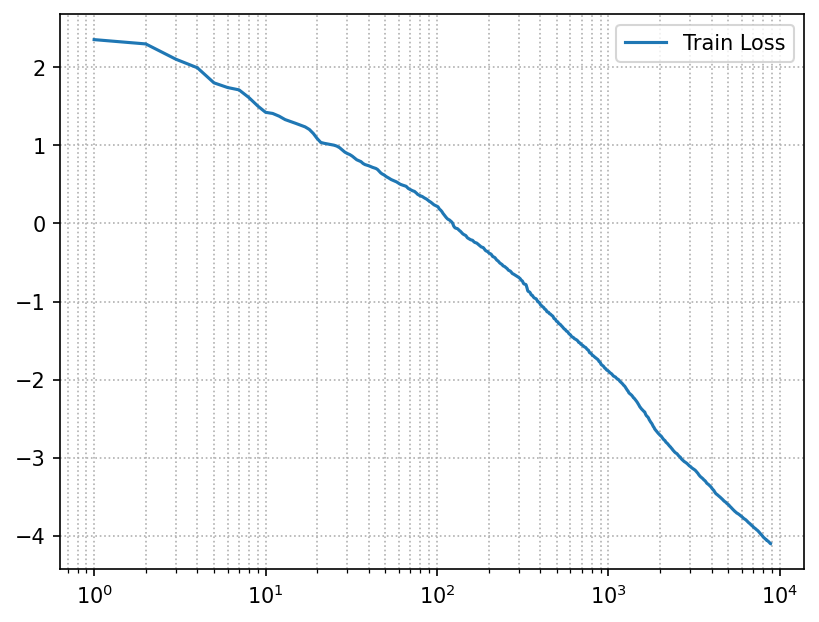

In [5]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=False)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

#### Save the training

In [6]:
torch.save(pinn.approximate_solution.state_dict(), 'approximate_solution_parameters.pth')

### Load the pre-trained pinn

In [7]:
pinn.approximate_solution.load_state_dict(torch.load("approximate_solution_parameters.pth"))

<All keys matched successfully>

### Plot the solution

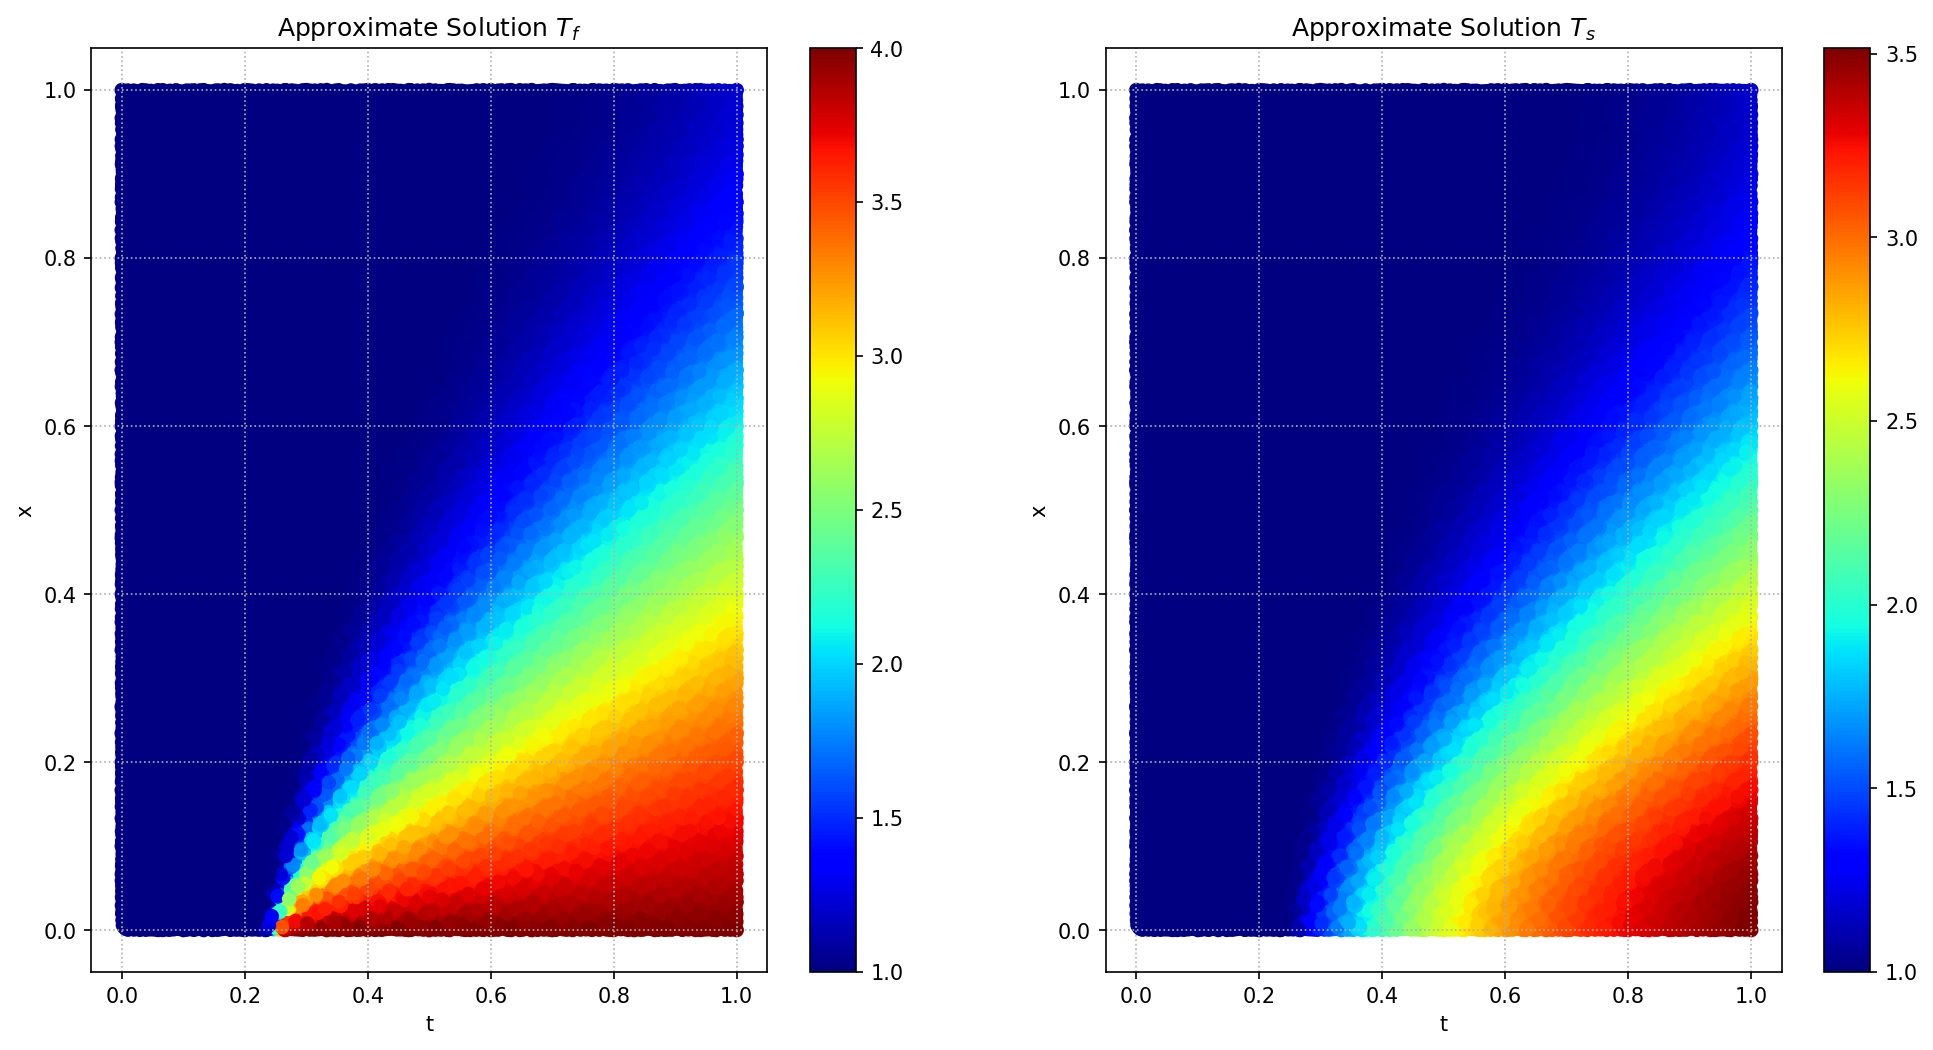

In [8]:
pinn.plotting()

### Make the predictions and save them

Text(0.5, 1.0, 'Approximate Solution $T_s$')

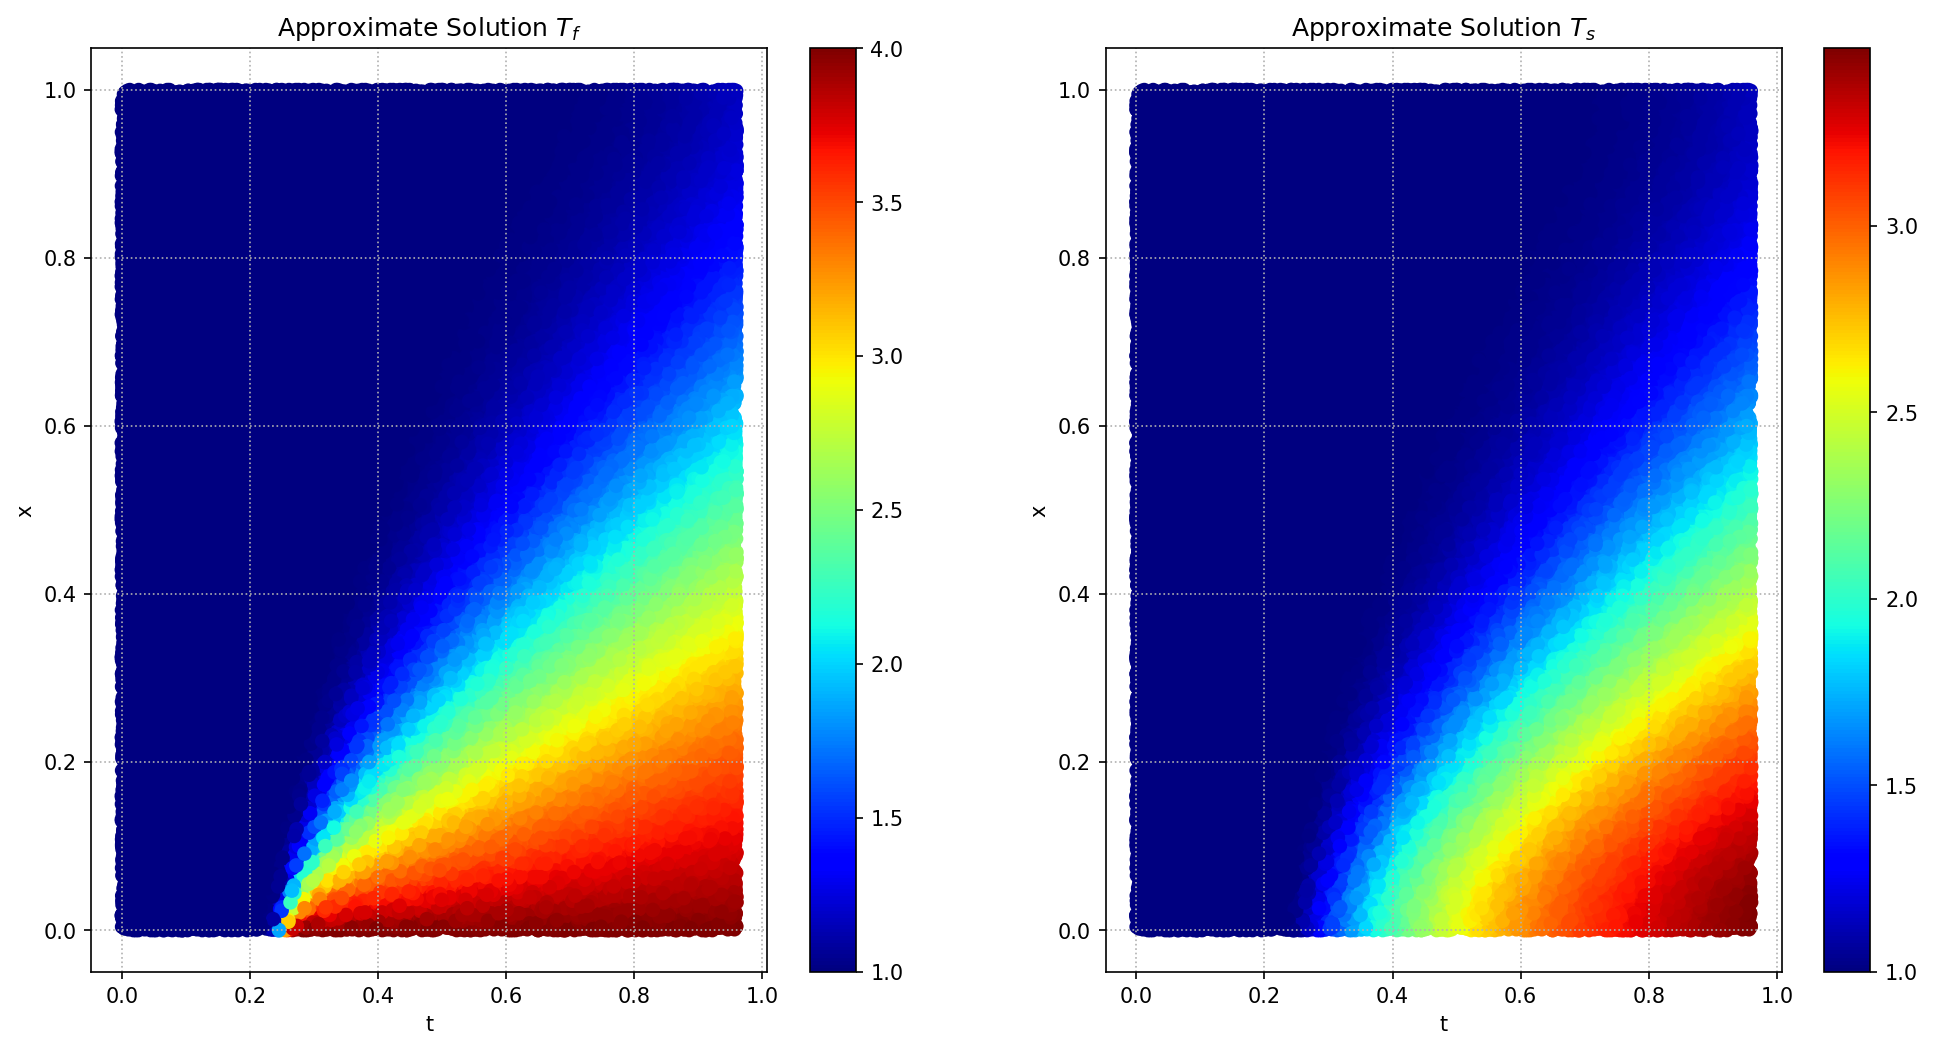

In [9]:
df_testing_data = pd.read_csv("TestingData.txt")
testing_data_input = torch.tensor(df_testing_data.values, dtype=torch.float)
testing_data_pred = pinn.approximate_solution(testing_data_input)

# Plot the predictions
testing_pred_Tf = testing_data_pred[:, 0]
testing_pred_Ts = testing_data_pred[:, 1]

# # Save the predictions
df_testing_data['tf'] = testing_pred_Tf.detach().numpy()
df_testing_data['ts'] = testing_pred_Ts.detach().numpy()

df_testing_data.to_csv('Task1.txt', index=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(testing_data_input[:, 0].detach(), testing_data_input[:, 1].detach(), c=testing_pred_Tf.detach(), cmap="jet")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(testing_data_input[:, 0].detach(), testing_data_input[:, 1].detach(), c=testing_pred_Ts.detach(), cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title(r"Approximate Solution $T_f$")
axs[1].set_title(r"Approximate Solution $T_s$")